In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import math
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# <span style="color:red">Functions</span>

In [7]:
def get_reactants(output, dataset):
    # stores indices
    T3014_ind = []
    T2955_ind = []
    T2954_ind = []
    
    data = dataset.loc[dataset['T3028 Batch [#]'] == output]
    data = data.reset_index()
    
    for i in range(data.shape[0]):
        if pd.isnull(data.loc[i]['Batch T3014 [#]'])==False:
            T3014_ind.append(i)
        if pd.isnull(data.loc[i]['Batch T2955 [#]'])==False:
            T2955_ind.append(i)
        if pd.isnull(data.loc[i]['Batch T2954 [#]'])==False:
            T2954_ind.append(i)
            
    # stores values at abtained indices
    T3014 = []
    T2955 = []
    T2954 = []

    for i in T3014_ind:
        T3014.append(data.loc[i]['Batch T3014 [#]'])

    for i in T2955_ind:
        T2955.append(data.loc[i]['Batch T2955 [#]'])
    
    for i in T2954_ind:
        T2954.append(data.loc[i]['Batch T2954 [#]'])
    
    # storing unique values and their counts
    T3014_uniq, count3014 = np.unique(T3014, return_counts=True)
    T2955_uniq, count2955 = np.unique(T2955, return_counts=True)
    T2954_uniq, count2954 = np.unique(T2954, return_counts=True)
    
    # return unique values of chemicals at each step and their batches for a selected output
    return T3014_uniq, count3014, T2955_uniq, count2955, T2954_uniq, count2954, data

In [8]:
def unique_non_null(s):
    # to find unique values ignoring NaN
    return s.dropna().unique()

In [9]:
def comb_T2954(dataset, data_combined_T2954):
    # for combining qualitative features of T2954 for each T2955
    
    # storing each T3028 names
    output = dataset['T3028 Batch [#]'].unique()
    
    for m in output:
        
        # for storing data for T3028 (one at a time)
        data = dataset.loc[dataset['T3028 Batch [#]'] == m]
        data = data.reset_index()
        del data['index']
        
        # new columns for storing qualitative features after using weighted sum
        data['Content_T2954 [%]']=None
        data['T2954_chiral_purity [%]']=None
        data['T2954_water-content [%]']=None
        data['R493916_in_T2954 [%]']=None
        
        # for storing indices of different T2955
        T2955_ind = []
        for i in range(data.shape[0]):
            if pd.isnull(data.loc[i]['Batch T2955 [#]'])==False:
                T2955_ind.append(i)
        
        # for storing names of different T2955
        T2955 = []
        for i in T2955_ind:
            T2955.append(data.loc[i]['Batch T2955 [#]'])
            
        indices = T2955_ind.copy()
        # extending indices by adding shape of dataframe (all T2954 from data)
        indices.append(data.shape[0])

        
        lim = 0
        
        # computing weighted sum of T2954 qualitative features
        for i in indices:
            if (indices[lim]!=data.shape[0]):
                lim = lim+1
                ulim = indices[lim]
        
                weight_T2954 = 0
                content_T2954 = 0
                chiral_T2954 = 0
                water_content_T2954 = 0
                R493916_T2954 = 0
        
                for j in range(i, ulim):
                    weight_T2954 = weight_T2954 + (data['Weight T2954 [kg]'][j])
                    content_T2954 = content_T2954 + (data['Weight T2954 [kg]'][j])*(data['Content T2954 [%]'][j])
                    chiral_T2954 = chiral_T2954 + (data['Weight T2954 [kg]'][j])*(data['T2954 chiral purity [%]'][j])
                    water_content_T2954 = water_content_T2954 + (data['Weight T2954 [kg]'][j])*(data['T2954 water-content [%]'][j])
                    R493916_T2954 = R493916_T2954 + (data['Weight T2954 [kg]'][j])*(data['R493916 in T2954 [%]'][j])
            
            
                content_T2954 = content_T2954/weight_T2954
                chiral_T2954 = chiral_T2954/weight_T2954
                water_content_T2954 = water_content_T2954/weight_T2954
                R493916_T2954 = R493916_T2954/weight_T2954
            
                # storing weighted sum of features in new columns
                data.loc[[i],'Content_T2954 [%]'] = content_T2954
                data.loc[[i],'T2954_chiral_purity [%]'] = chiral_T2954
                data.loc[[i],'T2954_water-content [%]'] = water_content_T2954
                data.loc[[i],'R493916_in_T2954 [%]'] = R493916_T2954
          
        # dropping empty rows
        data = data.dropna(axis=0, subset=['Batch T2955 [#]'] )
        
        # dropping old unessential columns
        data = data.drop(['Batch T2954 [#]', 'Weight T2954 [kg]', 'Content T2954 [%]', 
                          'T2954 chiral purity [%]', 
                          'T2954 water-content [%]', 'R493916 in T2954 [%]'], 1)
        
        data_combined_T2954 = data_combined_T2954.append(data, ignore_index = True)
        
    return data_combined_T2954

In [10]:
def duplicate_cols(dataset):
    # to check for duplicate columns (columns with same values)
    
    duplicateCols = set()
    
    for x in range(dataset.shape[1]):
        col = dataset.iloc[:,x]
        for y in range(x+1, dataset.shape[1]):
            othercol=dataset.iloc[:,y]
            
            if col.equals(othercol):
                duplicateCols.add(dataset.columns.values[y])
                
    return list(duplicateCols)

In [11]:
def comb_2955(dataset, data_combined_T2955):
    # for combining qualitative features of T2955 for each T3028
    
    # storing each T3028 names
    output = dataset['T3028 Batch [#]'].unique()
    
    for m in output:
        
        # for storing data for T3028 (one at a time)
        data = dataset.loc[dataset['T3028 Batch [#]'] == m]
        data = data.reset_index()
        del data['index']
        
        # new columns for storing qualitative features after using weighted sum
        data['Weight_T2955 [kg]']=None
        data['Content_T2955 [%]']=None
        data['T2955_chiral_purity [%]']=None
        data['T2955_water-content [%]']=None
        data['R493916_in_T2955 [%]']=None
        
        weight_T2955 = 0
        content_T2955 = 0
        chiral_T2955 = 0
        water_content_T2955 = 0
        R493916_T2955 = 0
        
        # computing weighted sum of T2955 qualitative features
        for j in range(data.shape[0]):
            weight_T2955 = weight_T2955 + (data['Weight T2955 [kg]'][j])
            content_T2955 = content_T2955 + (data['Weight T2955 [kg]'][j])*(data['Content_T2954 [%]'][j])
            chiral_T2955 = chiral_T2955 + (data['Weight T2955 [kg]'][j])*(data['T2954_chiral_purity [%]'][j])
            water_content_T2955 = water_content_T2955 + (data['Weight T2955 [kg]'][j])*(data['T2954_water-content [%]'][j])
            R493916_T2955 = R493916_T2955 + (data['Weight T2955 [kg]'][j])*(data['R493916_in_T2954 [%]'][j])
            
            
        content_T2955 = content_T2955/weight_T2955
        chiral_T2955 = chiral_T2955/weight_T2955
        water_content_T2955 = water_content_T2955/weight_T2955
        R493916_T2955 = R493916_T2955/weight_T2955
        
        # storing weighted sum of features in new columns
        data.loc[0,'Weight_T2955 [kg]'] = weight_T2955
        data.loc[0,'Content_T2955 [%]'] = content_T2955
        data.loc[0,'T2955_chiral_purity [%]'] = chiral_T2955
        data.loc[0,'T2955_water-content [%]'] = water_content_T2955
        data.loc[0,'R493916_in_T2955 [%]'] = R493916_T2955
        
        # dropping empty rows
        data = data.dropna(axis=0, subset=['Azeo-tropic Water [kg]'])
        
        # dropping old unessential columns
        data = data.drop(['Weight T2955 [kg]', 'Content_T2954 [%]', 'T2954_chiral_purity [%]',
                         'T2954_water-content [%]', 'R493916_in_T2954 [%]' ], 1)
        
        data_combined_T2955 = data_combined_T2955.append(data, ignore_index = True)
        
        
    return data_combined_T2955 

# <span style="color:red">Preprocessing of data</span>

1. Renaming columns for uniformity
2. Deleting rows with dependency on missing column data)
3. Filled empty rows of T3028 Batch, Yield T3028 with pd.ffill()
4. Removed (PV) in T3028 Batch
5. Added qualitative features of T3028 from Qualitat dataset

In [12]:
# loading updated dataset after preprocessing mentioned above
chargenbaum = pd.read_excel(r'M:\TechlabsWS21\new_data\UPDATED_ChargenbaumT3028_2021.xlsx', 
                            sheet_name='2021')
chargenbaum

,T3028 Batch [#],Total quantity T2955 used for T3028 [mol],Azeo-tropic Water [kg],Azeotropic 2-Me-THF [kg],Weight T3028 [kg],Quantity T3028 [mol],Yield T3028 [%],Batch T3014 [#],Quantity T2955 [mol]-1,Batch T2955 [#],...,T2955 - solution [kg],T2955 [kg],Quantity T2955 [mol]-3,Yield T2955 [%],T2954 chiral purity [%],T2954 water-content [%],R493916 in T2954 [%],GRT13643L in %,GRTE7765 in %,Jede weitere Verunreinigung in %
0,S0657,2042.1,131.5,740.0,486.517,1538.247755,79.647129,R2178,678.47,R0466,...,1353.5,751.906742,2991.235,98.735941,97.8,0.07,0.8,0.18,"0,13",0.09
1,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.0,0.06,0.8,0.18,"0,13",0.09
2,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,R2179,680.68,R0466,...,1353.5,751.906742,2991.235,98.735941,97.8,0.07,0.8,0.18,"0,13",0.09
3,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.0,0.06,0.8,0.18,"0,13",0.09
4,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,R2180,682.89,R0467,...,1355.0,752.740033,2994.550,98.935159,97.8,0.07,0.8,0.18,"0,13",0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,S0771,NaN,NaN,NaN,510.517,1614.129885,83.907581,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,96.6,0.05,0.9,0.05,"0,14",0.06
763,S0771,NaN,NaN,NaN,510.517,1614.129885,83.907581,NaN,NaN,S0570,...,1356.0,753.295561,2996.760,99.349982,96.6,0.05,0.9,0.05,"0,14",0.06
764,S0772,2034.4,131.5,733.0,508.517,1607.806374,84.023846,S2523,681.80,S0570,...,1356.0,753.295561,2996.760,99.349982,96.6,0.05,0.9,0.04,"0,13",0.04
765,S0772,NaN,NaN,NaN,508.517,1607.806374,84.023846,S2524,674.10,S0570,...,1356.0,753.295561,2996.760,99.349982,96.6,0.05,0.9,0.04,"0,13",0.04


In [13]:
list(chargenbaum.columns)

['T3028 Batch [#]',
 'Total quantity T2955 used for T3028 [mol]',
 'Azeo-tropic Water [kg]',
 'Azeotropic 2-Me-THF [kg]',
 'Weight T3028 [kg]',
 'Quantity T3028 [mol]',
 'Yield T3028 [%]',
 'Batch T3014 [#]',
 'Quantity T2955 [mol]-1',
 'Batch T2955 [#]',
 'Weight of solution T2955 [kg]',
 'T2955 SVZ [mol/kg]-1',
 'Weight T2955 [kg]',
 'Quantity T2955 [mol]-2',
 'Weight T2954 in T2955 [kg]',
 'Batch T2954 [#]',
 'Weight T2954 [kg]',
 'Content T2954 [%]',
 'Quantity T2954 content-corrected [mol]',
 'T2955 SVZ [mol/kg]-2',
 'T2955 - solution [kg]',
 'T2955 [kg]',
 'Quantity T2955 [mol]-3',
 'Yield T2955 [%]',
 'T2954 chiral purity [%]',
 'T2954 water-content [%]',
 'R493916 in T2954 [%]',
 'GRT13643L in %',
 'GRTE7765 in %',
 'Jede weitere Verunreinigung in %']

#### <span style="color:blue">Overview of Sliced data for selected ouput chemical</span>

In [14]:
# for a selected output T3028

output_product = 'S0657'
T3014_uniq, count3014, T2955_uniq, count2955, T2954_uniq, count2954, sliced_data = get_reactants(output_product, chargenbaum)
del sliced_data['index']

print(sliced_data[['T3028 Batch [#]','Batch T3014 [#]',
                   'Batch T2955 [#]','Batch T2954 [#]']])


# codes and quantity of chemicals used for producing 1 batch of selected ouput chemical

print('\nT3014')
print(T3014_uniq)
print(count3014)

print('\nT2955')
print(T2955_uniq)
print(count2955)

print('\nT2954')
print(T2954_uniq)
print(count2954)

  T3028 Batch [#] Batch T3014 [#] Batch T2955 [#] Batch T2954 [#]
0           S0657           R2178           R0466           R0241
1           S0657             NaN             NaN           R0242
2           S0657           R2179           R0466           R0241
3           S0657             NaN             NaN           R0242
4           S0657           R2180           R0467           R0242
5           S0657             NaN             NaN           R0243

T3014
['R2178' 'R2179' 'R2180']
[1 1 1]

T2955
['R0466' 'R0467']
[2 1]

T2954
['R0241' 'R0242' 'R0243']
[2 3 1]


#### <span style="color:blue">For whole data of a selected year</span>

<AxesSubplot:>

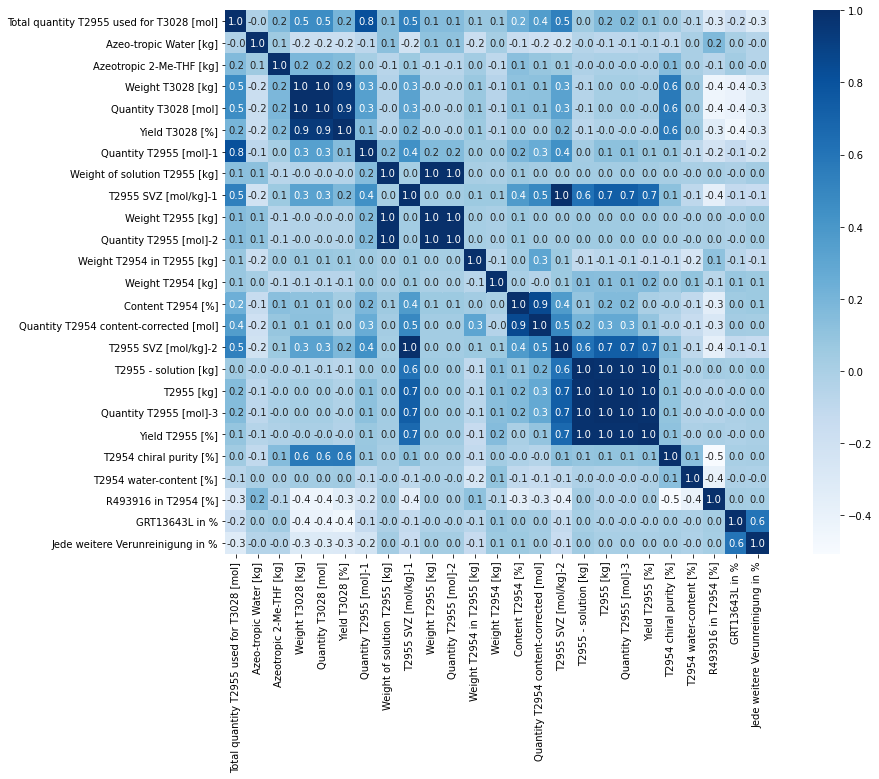

In [15]:
# correlation map to check effect of parameters

correlation = chargenbaum.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation, cbar=True, square=True, fmt= '.1f', annot= True, annot_kws= {'size':10}, cmap= 'Blues')

# <span style="color:red">Making uniform input</span>

Since all T3028 have multiple and varying inputs, try to bring uniformity in inputs.
Using weighted sum to find qualitative properties (approximately) of next step

#### <span style="color:blue">Combining different T2954 (weighted sum) properties for each T2955</span>

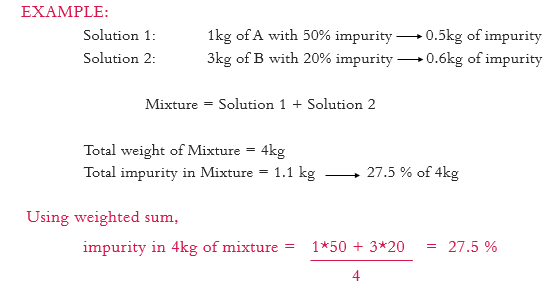

In [16]:
chargenbaum = pd.read_excel(r'M:\TechlabsWS21\new_data\UPDATED_ChargenbaumT3028_2021.xlsx', 
                            sheet_name='2021')

In [17]:
# combining qualitative features of T2954 for each T2955
data_combined_T2954 = pd.DataFrame()
data_combined_T2954 = comb_T2954(chargenbaum, data_combined_T2954)
data_combined_T2954

# data_combined_T2954.to_excel(r'M:\TechlabsWS21\new_data\combT2954_2019.xlsx', index = False)

,T3028 Batch [#],Total quantity T2955 used for T3028 [mol],Azeo-tropic Water [kg],Azeotropic 2-Me-THF [kg],Weight T3028 [kg],Quantity T3028 [mol],Yield T3028 [%],Batch T3014 [#],Quantity T2955 [mol]-1,Batch T2955 [#],...,T2955 [kg],Quantity T2955 [mol]-3,Yield T2955 [%],GRT13643L in %,GRTE7765 in %,Jede weitere Verunreinigung in %,Content_T2954 [%],T2954_chiral_purity [%],T2954_water-content [%],R493916_in_T2954 [%]
0,S0657,2042.1,131.5,740.0,486.517,1538.247755,79.647129,R2178,678.47,R0466,...,751.906742,2991.235,98.735941,0.18,"0,13",0.09,98.957196,97.068487,0.060856,0.8
1,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,R2179,680.68,R0466,...,751.906742,2991.235,98.735941,0.18,"0,13",0.09,98.957196,97.068487,0.060856,0.8
2,S0657,NaN,NaN,NaN,486.517,1538.247755,79.647129,R2180,682.89,R0467,...,752.740033,2994.550,98.935159,0.18,"0,13",0.09,98.86738,97.446347,0.065579,0.8
3,S0658,2034.4,130.5,731.0,497.018,1571.449349,81.771900,R2181,678.47,R0467,...,752.740033,2994.550,98.935159,0.13,"0,13",0.10,98.86738,97.088413,0.055579,0.8
4,S0658,NaN,NaN,NaN,497.018,1571.449349,81.771900,R2182,674.05,R0467,...,752.740033,2994.550,98.935159,0.13,"0,13",0.10,98.86738,97.088413,0.055579,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,S0771,NaN,NaN,NaN,510.517,1614.129885,83.907581,S2522,678.60,S0569,...,757.262180,3012.540,99.628059,0.05,"0,14",0.06,98.696755,97.083776,0.059676,0.803245
400,S0771,NaN,NaN,NaN,510.517,1614.129885,83.907581,NaN,NaN,S0570,...,753.295561,2996.760,99.349982,0.05,"0,14",0.06,98.6,96.6,0.05,0.9
401,S0772,2034.4,131.5,733.0,508.517,1607.806374,84.023846,S2523,681.80,S0570,...,753.295561,2996.760,99.349982,0.04,"0,13",0.04,98.6,96.6,0.05,0.9
402,S0772,NaN,NaN,NaN,508.517,1607.806374,84.023846,S2524,674.10,S0570,...,753.295561,2996.760,99.349982,0.04,"0,13",0.04,98.6,96.6,0.05,0.9


<AxesSubplot:>

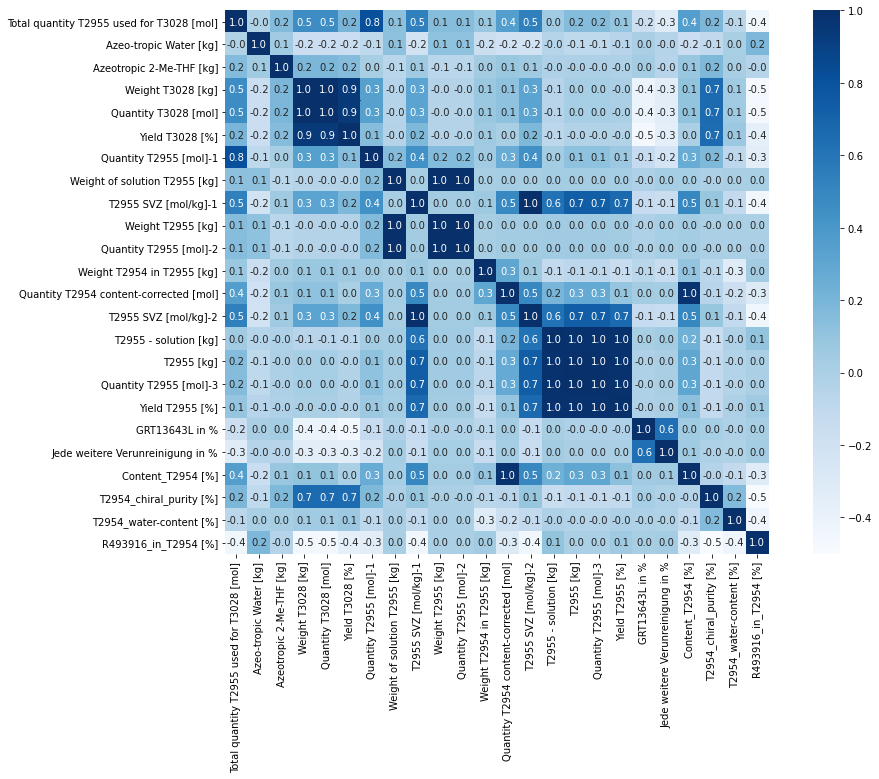

In [18]:
combT2954 = pd.read_excel(r'M:\TechlabsWS21\new_data\combT2954_2021.xlsx')

# correlation map to check effect of parameters

correlation = combT2954.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation, cbar=True, square=True, fmt= '.1f', annot= True, annot_kws= {'size':10}, cmap= 'Blues')

#### <span style="color:blue">Combining different T2955 (weighted sum) for properties of T3014 / T3028</span>

In [19]:
combT2954 = pd.read_excel(r'M:\TechlabsWS21\new_data\combT2954_2021.xlsx')

# dropping unessential columns
combT2954 = combT2954.drop(['Total quantity T2955 used for T3028 [mol]', 'Batch T3014 [#]', 'Quantity T2955 [mol]-1',
                          'Batch T2955 [#]', 'Weight of solution T2955 [kg]',
                          'T2955 SVZ [mol/kg]-1', 'Quantity T2955 [mol]-2',
                          'Weight T2954 in T2955 [kg]', 'Quantity T2954 content-corrected [mol]',
                          'T2955 SVZ [mol/kg]-2', 'T2955 - solution [kg]', 'T2955 [kg]',
                          'Quantity T2955 [mol]-3', 'Yield T2955 [%]',
                           'Weight T3028 [kg]', 'Quantity T3028 [mol]'], 1)

In [20]:
# combining qualitative features of T2955 for each T3028
data_combined_T2955 = pd.DataFrame()
data_combined_T2955 = comb_2955(combT2954, data_combined_T2955)
data_combined_T2955

# data_combined_T2955.to_excel(r'M:\TechlabsWS21\new_data\combT2955_2019.xlsx', index = False)

,T3028 Batch [#],Azeo-tropic Water [kg],Azeotropic 2-Me-THF [kg],Yield T3028 [%],GRT13643L in %,GRTE7765 in %,Jede weitere Verunreinigung in %,Weight_T2955 [kg],Content_T2955 [%],T2955_chiral_purity [%],T2955_water-content [%],R493916_in_T2955 [%]
0,S0657,131.5,740.0,79.647129,0.18,"0,13",0.09,513.307595,98.92716,97.194849,0.062436,0.8
1,S0658,130.5,731.0,81.771900,0.13,"0,13",0.10,511.363248,98.86738,97.088413,0.055579,0.8
2,S0659,127.5,732.5,81.484902,0.09,"0,09",0.12,510.184323,98.722144,97.185237,0.050738,0.8
3,S0660,133.5,744.5,80.016498,0.65,"0,13",0.19,510.061151,98.7,97.353843,0.065384,0.761539
4,S0661,134.0,736.0,84.047995,0.08,"0,09",0.13,507.836527,98.7,97.58787,0.088787,0.703033
...,...,...,...,...,...,...,...,...,...,...,...,...
105,S0768,131.5,734.0,84.203815,0.03,"0,15",0.04,511.418549,98.81944,97.859266,0.040058,0.700291
106,S0769,132.0,738.5,83.139045,0.03,"0,14",0.05,515.072212,98.875758,97.275758,0.042424,0.712121
107,S0770,132.5,735.0,83.464268,0.03,"0,11",0.04,517.583399,98.776462,97.169262,0.051994,0.762669
108,S0771,134.0,743.0,83.907581,0.05,"0,14",0.06,513.770116,98.689013,97.045067,0.058901,0.810987


<AxesSubplot:>

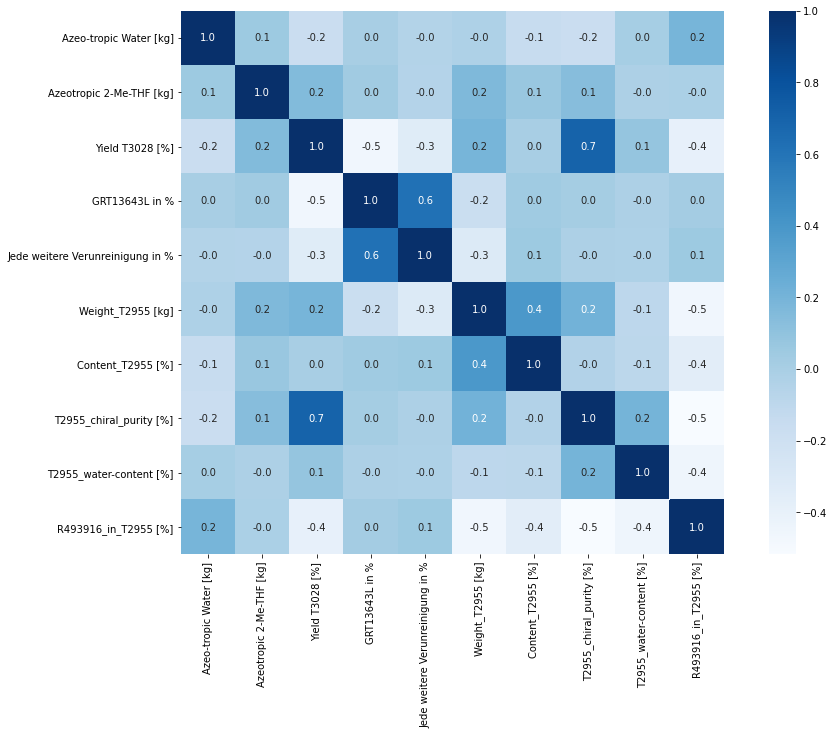

In [21]:
combT2955 = pd.read_excel(r'M:\TechlabsWS21\new_data\combT2955_2021.xlsx')

# correlation map to check effect of parameters

correlation = combT2955.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation, cbar=True, square=True, fmt= '.1f', annot= True, annot_kws= {'size':10}, cmap= 'Blues')

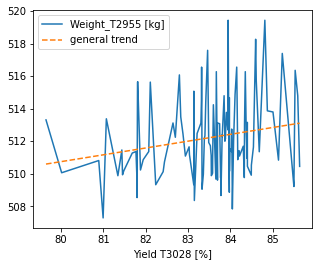

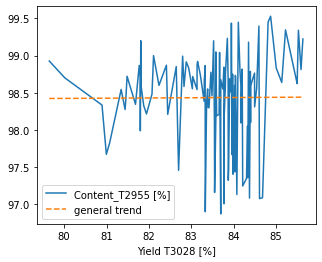

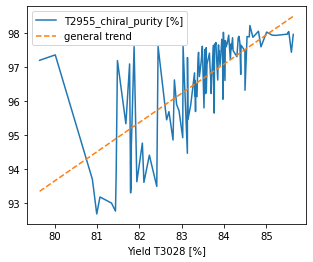

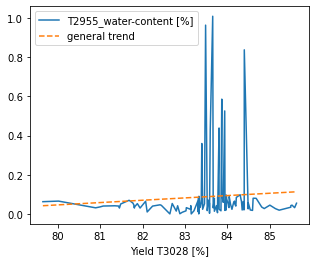

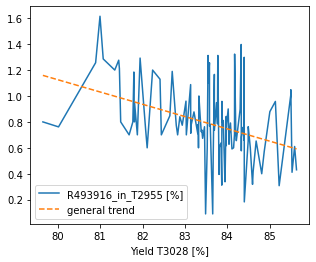

In [22]:
# sorting dataset using Yield of T3028
sorted_T2955 = combT2955.sort_values(by=['Yield T3028 [%]'])

# visualizing the effect of each parameter individually on yield of T3028
b, m = polyfit(sorted_T2955["Yield T3028 [%]"], sorted_T2955["Weight_T2955 [kg]"], 1)
sorted_T2955.plot(x="Yield T3028 [%]", y="Weight_T2955 [kg]", figsize=(5,4))
plt.plot(sorted_T2955["Yield T3028 [%]"], b + m * sorted_T2955["Yield T3028 [%]"], '--')
plt.legend(['Weight_T2955 [kg]','general trend'])
plt.show()

b, m = polyfit(sorted_T2955["Yield T3028 [%]"], sorted_T2955["Content_T2955 [%]"], 1)
sorted_T2955.plot(x="Yield T3028 [%]", y='Content_T2955 [%]', figsize=(5,4))
plt.plot(sorted_T2955["Yield T3028 [%]"], b + m * sorted_T2955["Yield T3028 [%]"], '--')
plt.legend(['Content_T2955 [%]','general trend'])
plt.show()

b, m = polyfit(sorted_T2955["Yield T3028 [%]"], sorted_T2955["T2955_chiral_purity [%]"], 1)
sorted_T2955.plot(x="Yield T3028 [%]", y="T2955_chiral_purity [%]", figsize=(5,4))
plt.plot(sorted_T2955["Yield T3028 [%]"], b + m * sorted_T2955["Yield T3028 [%]"], '--')
plt.legend(['T2955_chiral_purity [%]','general trend'])
plt.show()

b, m = polyfit(sorted_T2955["Yield T3028 [%]"], sorted_T2955["T2955_water-content [%]"], 1)
sorted_T2955.plot(x="Yield T3028 [%]", y='T2955_water-content [%]', figsize=(5,4))
plt.plot(sorted_T2955["Yield T3028 [%]"], b + m * sorted_T2955["Yield T3028 [%]"], '--')
plt.legend(['T2955_water-content [%]','general trend'])
plt.show()

b, m = polyfit(sorted_T2955["Yield T3028 [%]"], sorted_T2955["R493916_in_T2955 [%]"], 1)
sorted_T2955.plot(x="Yield T3028 [%]", y='R493916_in_T2955 [%]', figsize=(5,4))
plt.plot(sorted_T2955["Yield T3028 [%]"], b + m * sorted_T2955["Yield T3028 [%]"], '--')
plt.legend(['R493916_in_T2955 [%]','general trend'])
plt.show()

#### <span style="color:blue">Merging dataframes to combine data from all years</span>

In [23]:
# dataset of weighted sum qualitative features of all years
combIP_all = pd.read_excel(r'M:\TechlabsWS21\new_data\combT2955_ALLyears.xlsx')

<AxesSubplot:>

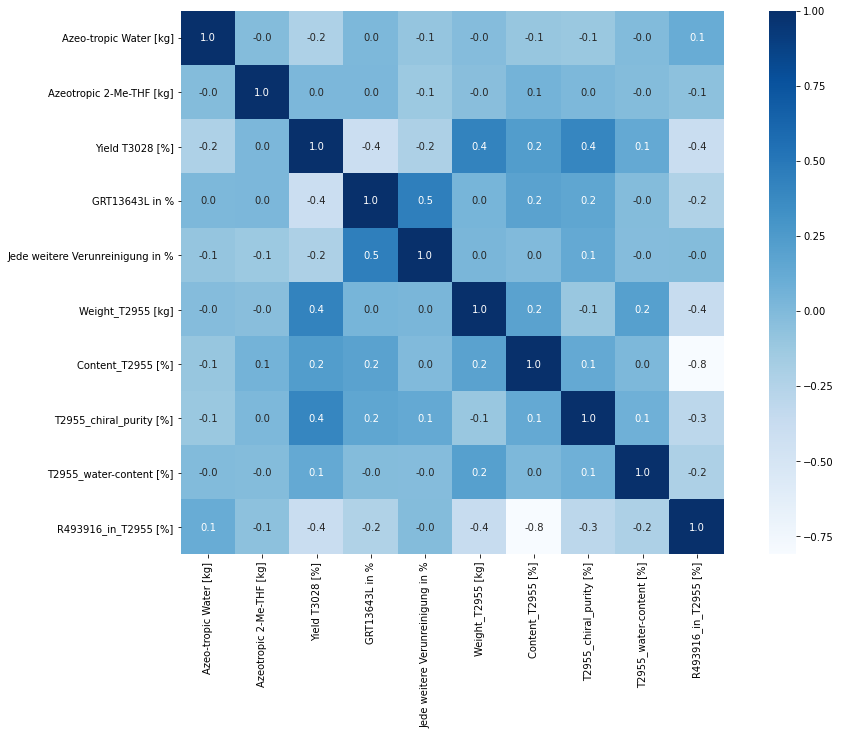

In [24]:
# correlation map to check effect of parameters

correlation = combIP_all.corr()
plt.figure(figsize=(16,10))
sns.heatmap(correlation, cbar=True, square=True, fmt= '.1f', annot= True, annot_kws= {'size':10}, cmap= 'Blues')

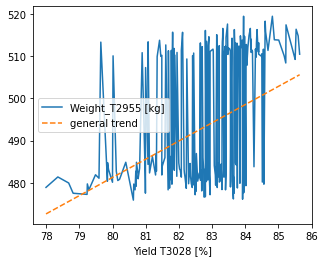

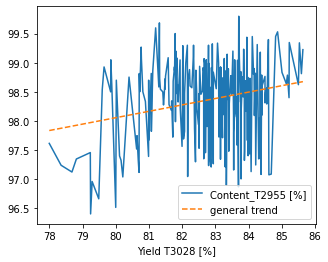

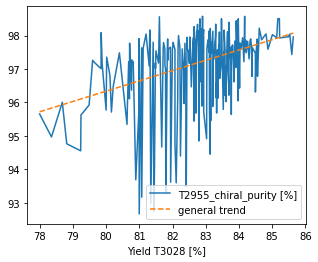

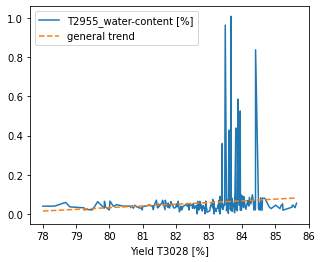

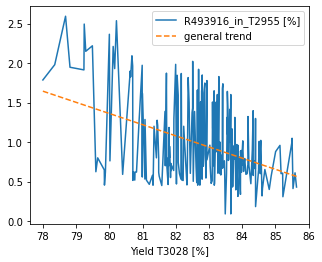

In [25]:
# sorting dataset using Yield of T3028
sorted_combIP_all = combIP_all.sort_values(by=['Yield T3028 [%]'])

# visualizing the effect of each parameter individually on yield of T3028
b, m = polyfit(sorted_combIP_all["Yield T3028 [%]"], sorted_combIP_all["Weight_T2955 [kg]"], 1)
sorted_combIP_all.plot(x="Yield T3028 [%]", y="Weight_T2955 [kg]", figsize=(5,4))
plt.plot(sorted_combIP_all["Yield T3028 [%]"], b + m * sorted_combIP_all["Yield T3028 [%]"], '--')
plt.legend(['Weight_T2955 [kg]','general trend'])
plt.show()

b, m = polyfit(sorted_combIP_all["Yield T3028 [%]"], sorted_combIP_all["Content_T2955 [%]"], 1)
sorted_combIP_all.plot(x="Yield T3028 [%]", y='Content_T2955 [%]', figsize=(5,4))
plt.plot(sorted_combIP_all["Yield T3028 [%]"], b + m * sorted_combIP_all["Yield T3028 [%]"], '--')
plt.legend(['Content_T2955 [%]','general trend'])
plt.show()

b, m = polyfit(sorted_combIP_all["Yield T3028 [%]"], sorted_combIP_all["T2955_chiral_purity [%]"], 1)
sorted_combIP_all.plot(x="Yield T3028 [%]", y="T2955_chiral_purity [%]", figsize=(5,4))
plt.plot(sorted_combIP_all["Yield T3028 [%]"], b + m * sorted_combIP_all["Yield T3028 [%]"], '--')
plt.legend(['T2955_chiral_purity [%]','general trend'])
plt.show()

b, m = polyfit(sorted_combIP_all["Yield T3028 [%]"], sorted_combIP_all["T2955_water-content [%]"], 1)
sorted_combIP_all.plot(x="Yield T3028 [%]", y='T2955_water-content [%]', figsize=(5,4))
plt.plot(sorted_combIP_all["Yield T3028 [%]"], b + m * sorted_combIP_all["Yield T3028 [%]"], '--')
plt.legend(['T2955_water-content [%]','general trend'])
plt.show()

b, m = polyfit(sorted_combIP_all["Yield T3028 [%]"], sorted_combIP_all["R493916_in_T2955 [%]"], 1)
sorted_combIP_all.plot(x="Yield T3028 [%]", y='R493916_in_T2955 [%]', figsize=(5,4))
plt.plot(sorted_combIP_all["Yield T3028 [%]"], b + m * sorted_combIP_all["Yield T3028 [%]"], '--')
plt.legend(['R493916_in_T2955 [%]','general trend'])
plt.show()

#### <span style="color:blue">Mean values of each parameter for each year</span>

In [27]:
# loading data containing features dependent on T2955,T2954
mean_dataT2955_2021 = pd.read_excel(r'M:\TechlabsWS21\new_data\for_mean_T2955_2021.xlsx')
mean_dataT2955_2020 = pd.read_excel(r'M:\TechlabsWS21\new_data\for_mean_T2955_2020.xlsx')
mean_dataT2955_2019 = pd.read_excel(r'M:\TechlabsWS21\new_data\for_mean_T2955_2019.xlsx')

# computing mean of each column
mean2021 = mean_dataT2955_2021.mean()
mean2020 = mean_dataT2955_2020.mean()
mean2019 = mean_dataT2955_2019.mean()

# storing mean of qualitative features from each year in an array
yieldT = [mean2021[0], mean2020[0], mean2019[0]]
weight = [mean2021[1], mean2020[1], mean2019[1]]
contentT = [mean2021[2], mean2020[2], mean2019[2]]
chiral = [mean2021[3], mean2020[3], mean2019[3]]
water_content = [mean2021[4], mean2020[4], mean2019[4]]
R493916 = [mean2021[5], mean2020[5], mean2019[5]]

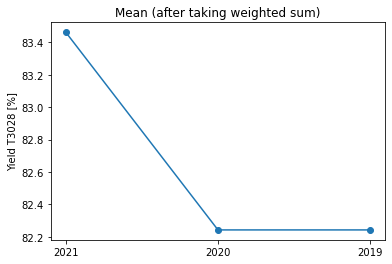

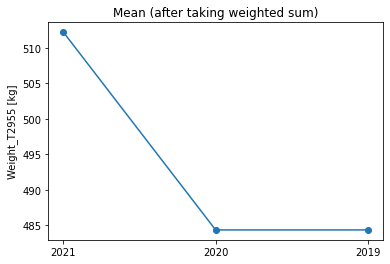

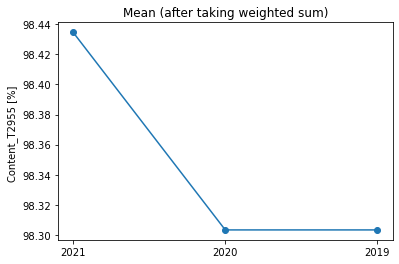

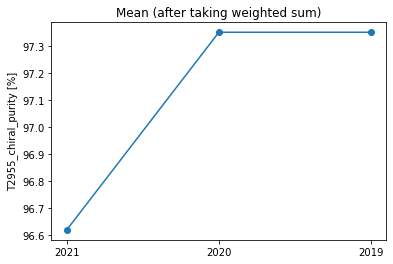

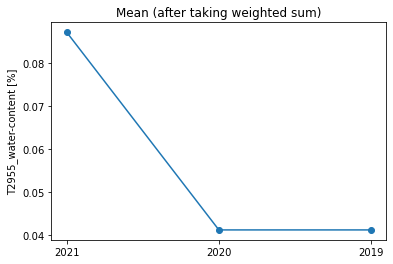

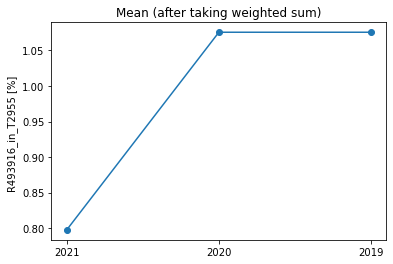

In [28]:
# plotting mean of qualitative features from each year
x = ['2021', '2020', '2019']

plt.plot(x, yieldT, '-o')
plt.ylabel('Yield T3028 [%]')
plt.title('Mean (after taking weighted sum)')
plt.show()

plt.plot(x, weight, '-o')
plt.ylabel('Weight_T2955 [kg]')
plt.title('Mean (after taking weighted sum)')
plt.show()

plt.plot(x, contentT, '-o')
plt.ylabel('Content_T2955 [%] ')
plt.title('Mean (after taking weighted sum)')
plt.show()

plt.plot(x, chiral, '-o')
plt.ylabel('T2955_chiral_purity [%]')
plt.title('Mean (after taking weighted sum)')
plt.show()

plt.plot(x, water_content, '-o')
plt.ylabel('T2955_water-content [%]')
plt.title('Mean (after taking weighted sum)')
plt.show()

plt.plot(x, R493916, '-o')
plt.ylabel('R493916_in_T2955 [%] ')
plt.title('Mean (after taking weighted sum)')
plt.show()

In [4]:
temp = pd.read_excel(r'M:\TechlabsWS21\new_data\Chargenbaum T3028.xlsx', 
                            sheet_name='2019')

In [3]:
temp.dtypes

T3028 Batch\n[#]                              object
Total quantity T2955 used for T3028 [mol]    float64
Azeo-tropic Water [kg]                        object
Azeotropic 2-Me-THF [kg]                      object
Weight T3028 [kg]                            float64
Quantity T3028 [mol]                         float64
Yield T3028 [%]                              float64
Batch T3014 [#]                               object
Quantity T2955 [mol]                         float64
Batch T2955            [#]                    object
Weight of solution T2955            [kg]     float64
T2955\nSVZ [mol/kg]                          float64
Weight T2955             [kg]                float64
Quantity T2955             [mol]             float64
Weight T2954  in T2955 [kg]                  float64
Batch T2954        [#]                        object
Weight T2954 \n[kg]                          float64
Content T2954 [%]                            float64
Quantity T2954 content-corrected [mol]       f